In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')

from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import Birch
from sklearn.metrics import davies_bouldin_score,calinski_harabasz_score
from sklearn.ensemble import RandomForestClassifier


from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/MyDrive/Others/Machine Learning/Final Project/Creating Cohorts of Songs/'

!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Others/Machine Learning/Final Project/Creating Cohorts of Songs
Reference  rolling_stones_spotify.csv


In [2]:
class SongCohort:

  def __init__(self):
    self.df = pd.read_csv('rolling_stones_spotify.csv')
    self.df_dataset = self.df.copy()

  def get_dataset(self):
    if 'Unnamed: 0' in self.df_dataset.columns:
      self.df_dataset = self.df_dataset.drop(['Unnamed: 0'], axis=1)

    self.df_dataset['release_date'] = pd.to_datetime(self.df_dataset['release_date'],format = '%Y-%m-%d')
    obj_columns = self.df_dataset.select_dtypes(include='object').columns
    return self.df_dataset

  def dataset_Overview(self):
    print('-'*100)
    df_rows, df_col = self.df_dataset.shape
    print(f'The dataset has {df_rows} rows and {df_col} columns')
    print('-'*100)

    print('Info \n', self.df_dataset.info())
    print('-'*100)

    print('Describe \n', self.df_dataset.describe().T)
    print('-'*100)

  def Check_for_null_values(self):
    null_count = self.df_dataset.isnull().sum()
    nan_count = self.df_dataset.isna().sum()

    if (null_count.any() or nan_count.any()):
      print('There are null values in the dataset\n',null_count)
      print('There are nan values in the dataset\n',nan_count)
    else:
      print('There are no null values in the dataset\n',null_count)
      print('There are no nan values in the dataset\n',nan_count)
    return self.df_dataset

  def Check_For_Duplicates(self):
    duplicate_entries = self.df_dataset[self.df_dataset.duplicated()]

    if not duplicate_entries.empty:
      print('There are duplicate entries in the dataset\n',duplicate_entries)
    else:
      print('There are no duplicate entries in the dataset\n')

    return self.df_dataset

  def Replace_Infinity_Value(self):
    inf_columns = self.df_dataset.columns[self.df_dataset.isin([np.inf, -np.inf]).any()]
    print(inf_columns.to_list())
    if inf_columns.any():
      self.df_dataset[inf_columns] = self.df_dataset[inf_columns].replace([np.inf, -np.inf], np.nan)
      for col in inf_columns:
        self.df_dataset[col].fillna(self.df_dataset[col].mean(),inplace=True)

    else:
      print('There are no infinity values in the dataset\n')
    return self.df_dataset

  def Drop_erroneous_data(self):
    feature_col = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity']
    for col in feature_col:
      self.df_dataset = self.df_dataset[self.df_dataset[col].between(0,1)]
    return self.df_dataset



ObjSong = SongCohort()
df_song= ObjSong.get_dataset()


In [3]:
df_song.head()



,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,Concert Intro Music - Live,Licked Live In NYC,2022-06-10,1,2IEkywLJ4ykbhi1yRQvmsT,spotify:track:2IEkywLJ4ykbhi1yRQvmsT,0.0824,0.463,0.993,0.996000,0.932,-12.913,0.1100,118.001,0.0302,33,48640
1,Street Fighting Man - Live,Licked Live In NYC,2022-06-10,2,6GVgVJBKkGJoRfarYRvGTU,spotify:track:6GVgVJBKkGJoRfarYRvGTU,0.4370,0.326,0.965,0.233000,0.961,-4.803,0.0759,131.455,0.3180,34,253173
2,Start Me Up - Live,Licked Live In NYC,2022-06-10,3,1Lu761pZ0dBTGpzxaQoZNW,spotify:track:1Lu761pZ0dBTGpzxaQoZNW,0.4160,0.386,0.969,0.400000,0.956,-4.936,0.1150,130.066,0.3130,34,263160
3,If You Can't Rock Me - Live,Licked Live In NYC,2022-06-10,4,1agTQzOTUnGNggyckEqiDH,spotify:track:1agTQzOTUnGNggyckEqiDH,0.5670,0.369,0.985,0.000107,0.895,-5.535,0.1930,132.994,0.1470,32,305880
4,Don’t Stop - Live,Licked Live In NYC,2022-06-10,5,7piGJR8YndQBQWVXv6KtQw,spotify:track:7piGJR8YndQBQWVXv6KtQw,0.4000,0.303,0.969,0.055900,0.966,-5.098,0.0930,130.533,0.2060,32,305106


In [4]:
df_song=ObjSong.Replace_Infinity_Value()
df_song

[]
There are no infinity values in the dataset



,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,Concert Intro Music - Live,Licked Live In NYC,2022-06-10,1,2IEkywLJ4ykbhi1yRQvmsT,spotify:track:2IEkywLJ4ykbhi1yRQvmsT,0.0824,0.463,0.993,0.996000,0.9320,-12.913,0.1100,118.001,0.0302,33,48640
1,Street Fighting Man - Live,Licked Live In NYC,2022-06-10,2,6GVgVJBKkGJoRfarYRvGTU,spotify:track:6GVgVJBKkGJoRfarYRvGTU,0.4370,0.326,0.965,0.233000,0.9610,-4.803,0.0759,131.455,0.3180,34,253173
2,Start Me Up - Live,Licked Live In NYC,2022-06-10,3,1Lu761pZ0dBTGpzxaQoZNW,spotify:track:1Lu761pZ0dBTGpzxaQoZNW,0.4160,0.386,0.969,0.400000,0.9560,-4.936,0.1150,130.066,0.3130,34,263160
3,If You Can't Rock Me - Live,Licked Live In NYC,2022-06-10,4,1agTQzOTUnGNggyckEqiDH,spotify:track:1agTQzOTUnGNggyckEqiDH,0.5670,0.369,0.985,0.000107,0.8950,-5.535,0.1930,132.994,0.1470,32,305880
4,Don’t Stop - Live,Licked Live In NYC,2022-06-10,5,7piGJR8YndQBQWVXv6KtQw,spotify:track:7piGJR8YndQBQWVXv6KtQw,0.4000,0.303,0.969,0.055900,0.9660,-5.098,0.0930,130.533,0.2060,32,305106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,Carol,The Rolling Stones,1964-04-16,8,08l7M5UpRnffGl0FyuRiQZ,spotify:track:08l7M5UpRnffGl0FyuRiQZ,0.1570,0.466,0.932,0.006170,0.3240,-9.214,0.0429,177.340,0.9670,39,154080
1606,Tell Me,The Rolling Stones,1964-04-16,9,3JZllQBsTM6WwoJdzFDLhx,spotify:track:3JZllQBsTM6WwoJdzFDLhx,0.0576,0.509,0.706,0.000002,0.5160,-9.427,0.0843,122.015,0.4460,36,245266
1607,Can I Get A Witness,The Rolling Stones,1964-04-16,10,0t2qvfSBQ3Y08lzRRoVTdb,spotify:track:0t2qvfSBQ3Y08lzRRoVTdb,0.3710,0.790,0.774,0.000000,0.0669,-7.961,0.0720,97.035,0.8350,30,176080
1608,You Can Make It If You Try,The Rolling Stones,1964-04-16,11,5ivIs5vwSj0RChOIvlY3On,spotify:track:5ivIs5vwSj0RChOIvlY3On,0.2170,0.700,0.546,0.000070,0.1660,-9.567,0.0622,102.634,0.5320,27,121680


In [5]:
df_song=ObjSong.dataset_Overview()
df_song

----------------------------------------------------------------------------------------------------
The dataset has 1610 rows and 17 columns
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              1610 non-null   object        
 1   album             1610 non-null   object        
 2   release_date      1610 non-null   datetime64[ns]
 3   track_number      1610 non-null   int64         
 4   id                1610 non-null   object        
 5   uri               1610 non-null   object        
 6   acousticness      1610 non-null   float64       
 7   danceability      1610 non-null   float64       
 8   energy            1610 non-null   float64       
 9   instrumentalness  1610 non-null   float64       
 1

In [6]:
df_song = ObjSong.Check_for_null_values()
df_song

There are no null values in the dataset
 name                0
album               0
release_date        0
track_number        0
id                  0
uri                 0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
duration_ms         0
dtype: int64
There are no nan values in the dataset
 name                0
album               0
release_date        0
track_number        0
id                  0
uri                 0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
duration_ms         0
dtype: int64


,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,Concert Intro Music - Live,Licked Live In NYC,2022-06-10,1,2IEkywLJ4ykbhi1yRQvmsT,spotify:track:2IEkywLJ4ykbhi1yRQvmsT,0.0824,0.463,0.993,0.996000,0.9320,-12.913,0.1100,118.001,0.0302,33,48640
1,Street Fighting Man - Live,Licked Live In NYC,2022-06-10,2,6GVgVJBKkGJoRfarYRvGTU,spotify:track:6GVgVJBKkGJoRfarYRvGTU,0.4370,0.326,0.965,0.233000,0.9610,-4.803,0.0759,131.455,0.3180,34,253173
2,Start Me Up - Live,Licked Live In NYC,2022-06-10,3,1Lu761pZ0dBTGpzxaQoZNW,spotify:track:1Lu761pZ0dBTGpzxaQoZNW,0.4160,0.386,0.969,0.400000,0.9560,-4.936,0.1150,130.066,0.3130,34,263160
3,If You Can't Rock Me - Live,Licked Live In NYC,2022-06-10,4,1agTQzOTUnGNggyckEqiDH,spotify:track:1agTQzOTUnGNggyckEqiDH,0.5670,0.369,0.985,0.000107,0.8950,-5.535,0.1930,132.994,0.1470,32,305880
4,Don’t Stop - Live,Licked Live In NYC,2022-06-10,5,7piGJR8YndQBQWVXv6KtQw,spotify:track:7piGJR8YndQBQWVXv6KtQw,0.4000,0.303,0.969,0.055900,0.9660,-5.098,0.0930,130.533,0.2060,32,305106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,Carol,The Rolling Stones,1964-04-16,8,08l7M5UpRnffGl0FyuRiQZ,spotify:track:08l7M5UpRnffGl0FyuRiQZ,0.1570,0.466,0.932,0.006170,0.3240,-9.214,0.0429,177.340,0.9670,39,154080
1606,Tell Me,The Rolling Stones,1964-04-16,9,3JZllQBsTM6WwoJdzFDLhx,spotify:track:3JZllQBsTM6WwoJdzFDLhx,0.0576,0.509,0.706,0.000002,0.5160,-9.427,0.0843,122.015,0.4460,36,245266
1607,Can I Get A Witness,The Rolling Stones,1964-04-16,10,0t2qvfSBQ3Y08lzRRoVTdb,spotify:track:0t2qvfSBQ3Y08lzRRoVTdb,0.3710,0.790,0.774,0.000000,0.0669,-7.961,0.0720,97.035,0.8350,30,176080
1608,You Can Make It If You Try,The Rolling Stones,1964-04-16,11,5ivIs5vwSj0RChOIvlY3On,spotify:track:5ivIs5vwSj0RChOIvlY3On,0.2170,0.700,0.546,0.000070,0.1660,-9.567,0.0622,102.634,0.5320,27,121680


In [7]:
#df_song = ObjSong.Drop_erroneous_data()
df_song


,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,Concert Intro Music - Live,Licked Live In NYC,2022-06-10,1,2IEkywLJ4ykbhi1yRQvmsT,spotify:track:2IEkywLJ4ykbhi1yRQvmsT,0.0824,0.463,0.993,0.996000,0.9320,-12.913,0.1100,118.001,0.0302,33,48640
1,Street Fighting Man - Live,Licked Live In NYC,2022-06-10,2,6GVgVJBKkGJoRfarYRvGTU,spotify:track:6GVgVJBKkGJoRfarYRvGTU,0.4370,0.326,0.965,0.233000,0.9610,-4.803,0.0759,131.455,0.3180,34,253173
2,Start Me Up - Live,Licked Live In NYC,2022-06-10,3,1Lu761pZ0dBTGpzxaQoZNW,spotify:track:1Lu761pZ0dBTGpzxaQoZNW,0.4160,0.386,0.969,0.400000,0.9560,-4.936,0.1150,130.066,0.3130,34,263160
3,If You Can't Rock Me - Live,Licked Live In NYC,2022-06-10,4,1agTQzOTUnGNggyckEqiDH,spotify:track:1agTQzOTUnGNggyckEqiDH,0.5670,0.369,0.985,0.000107,0.8950,-5.535,0.1930,132.994,0.1470,32,305880
4,Don’t Stop - Live,Licked Live In NYC,2022-06-10,5,7piGJR8YndQBQWVXv6KtQw,spotify:track:7piGJR8YndQBQWVXv6KtQw,0.4000,0.303,0.969,0.055900,0.9660,-5.098,0.0930,130.533,0.2060,32,305106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,Carol,The Rolling Stones,1964-04-16,8,08l7M5UpRnffGl0FyuRiQZ,spotify:track:08l7M5UpRnffGl0FyuRiQZ,0.1570,0.466,0.932,0.006170,0.3240,-9.214,0.0429,177.340,0.9670,39,154080
1606,Tell Me,The Rolling Stones,1964-04-16,9,3JZllQBsTM6WwoJdzFDLhx,spotify:track:3JZllQBsTM6WwoJdzFDLhx,0.0576,0.509,0.706,0.000002,0.5160,-9.427,0.0843,122.015,0.4460,36,245266
1607,Can I Get A Witness,The Rolling Stones,1964-04-16,10,0t2qvfSBQ3Y08lzRRoVTdb,spotify:track:0t2qvfSBQ3Y08lzRRoVTdb,0.3710,0.790,0.774,0.000000,0.0669,-7.961,0.0720,97.035,0.8350,30,176080
1608,You Can Make It If You Try,The Rolling Stones,1964-04-16,11,5ivIs5vwSj0RChOIvlY3On,spotify:track:5ivIs5vwSj0RChOIvlY3On,0.2170,0.700,0.546,0.000070,0.1660,-9.567,0.0622,102.634,0.5320,27,121680


In [8]:
df_song = ObjSong.Check_For_Duplicates()

There are no duplicate entries in the dataset



In [9]:
class OutlierDeduction:
  def __init__(self,df):
    self.df = df
    self.df_dataset = self.df.copy()
    self.features_Column = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity','duration_ms']
    self.df_Features = self.df_dataset[self.features_Column]

  def Plot_before_Oultier_Deduction(self):

    plt.figure(figsize=(15,10))
    for indx, col_plt in enumerate(self.features_Column):
      plt.subplot(len(self.features_Column)//3+1,3,indx+1)
      #sns.scatterplot(data=self.df_Features, x=col_plt,y='duration_ms',hue = self.df_dataset['name'])
      sns.scatterplot(data=self.df_Features, x=col_plt,y='duration_ms')
      plt.tight_layout()
    plt.show()
    plt.figure(figsize=(15,10))
    for indx, col_plt in enumerate(self.features_Column):
      plt.subplot(len(self.features_Column)//3+1,3,indx+1)
      #sns.scatterplot(data=self.df_Features, x=col_plt,y='duration_ms',hue = self.df_dataset['name'])
      sns.boxplot(data=self.df_Features[col_plt])
      plt.tight_layout()
    plt.show()

  def OutlierDeduction(self,deduction_type='iqr'):

    if deduction_type.lower().strip() == 'iqr':
      Quantile_1 = self.df_Features.quantile(0.25)
      Quantile_3 = self.df_Features.quantile(0.75)
      IQR = Quantile_3 - Quantile_1
      outliers = (self.df_Features < (Quantile_1 - 1.5 * IQR)) | (self.df_Features > (Quantile_3 + 1.5 * IQR))

    elif deduction_type.lower().strip() == 'zscore':
      z_score  = np.abs(stats.zscore(self.df_Features))
      outliers = np.any(z_score > 3, axis=1)

    elif deduction_type.lower().strip() == 'lof':
      lof = LocalOutlierFactor()
      prediction_lof = lof.fit_predict(self.df_Features)
      outliers = prediction_lof ==-1


    elif deduction_type.lower().strip() == 'modifiedzscore':
      median_value = self.df_Features.median()
      mad = np.median(np.abs(self.df_Features - median_value),axis =0)
      modified_score = 0.6475 * ((self.df_Features - median_value)/mad)
      outliers = np.abs(modified_score) > 3.5


    else:
      print('Invlalid Outlier deduction type passed, select either one of the following \n')

      print('iqr \n')
      print('zscore \n')

      print('lof \n')
      print('modifiedzscore')


    for col in self.features_Column:
      self.df_Features.loc[outliers[col], col] = self.df_Features.loc[~outliers[col], col].mean()
      self.df_Features[col] = self.df_Features[col].fillna(self.df_Features[col].mean())



    plt.figure(figsize=(15,10))
    for indx, col_plt in enumerate(self.features_Column):
      plt.subplot(len(self.features_Column)//3+1,3,indx+1)

      sns.scatterplot(data=self.df_Features, x=col_plt,y='duration_ms')
      plt.tight_layout()
    plt.show()


    # plt.show()

    return self.df_Features,outliers






ObjOutlier = OutlierDeduction(df_song)

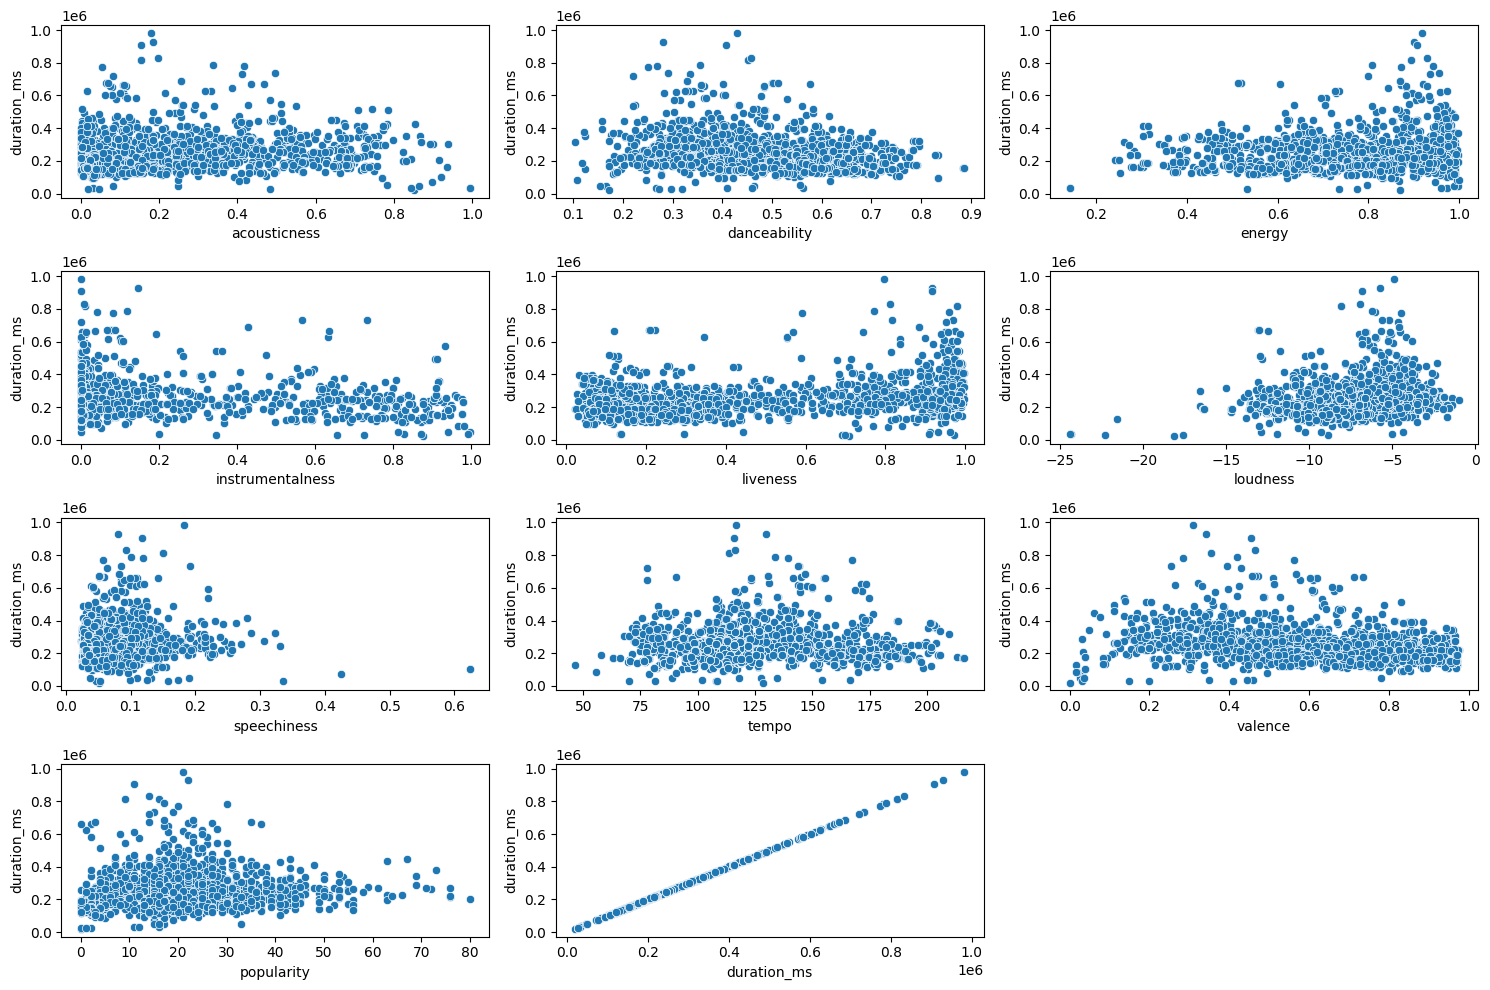

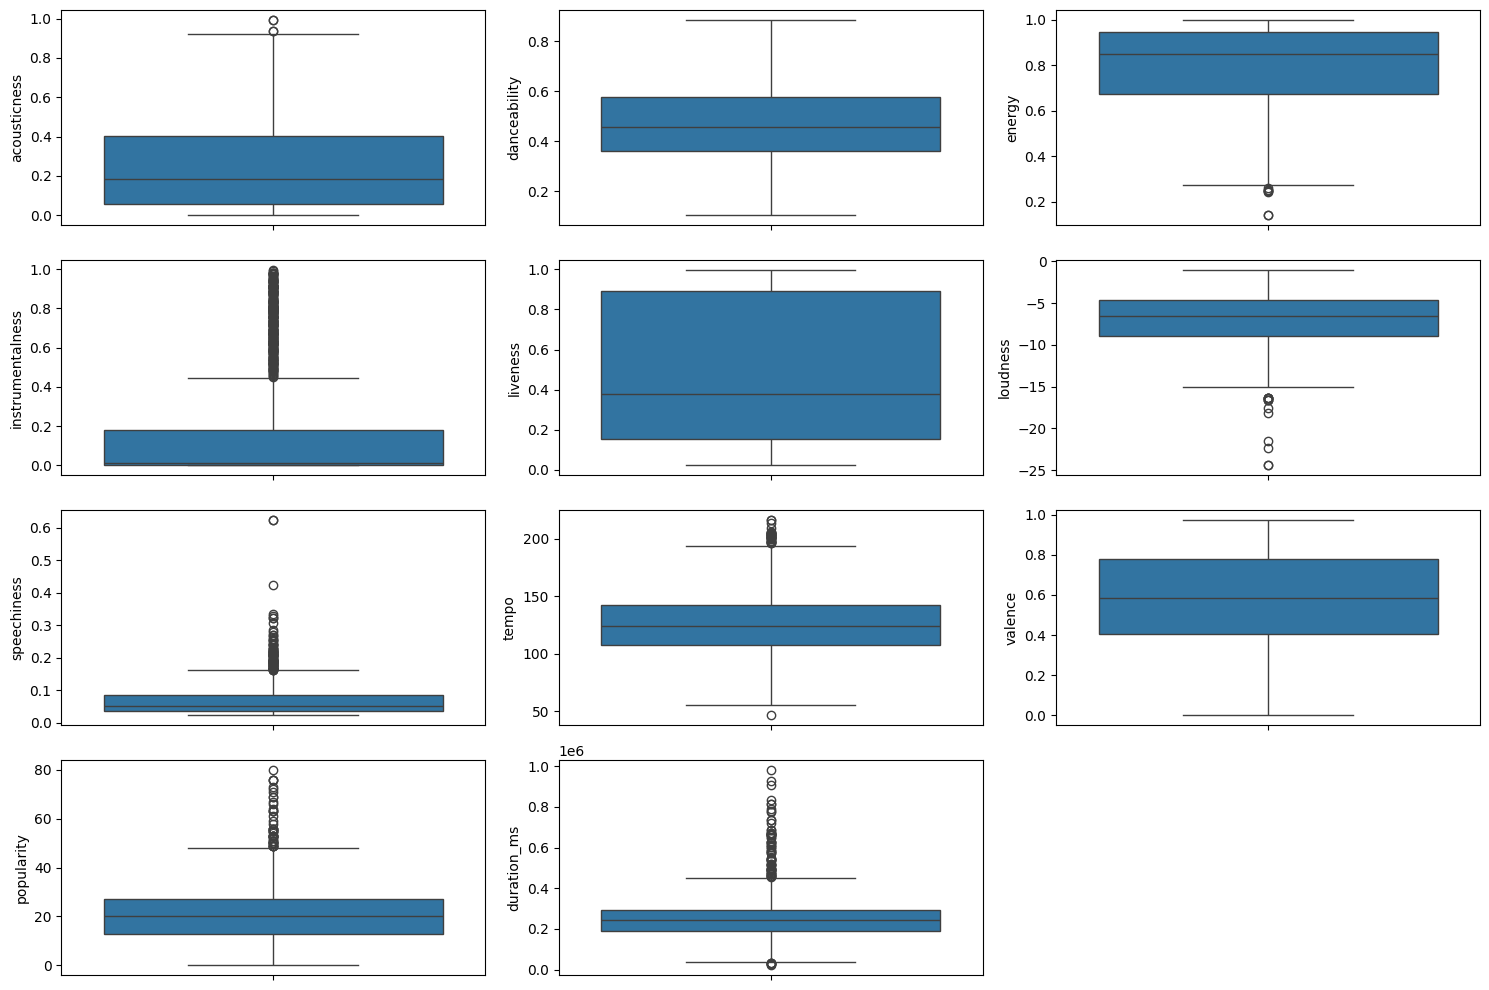

In [10]:

ObjOutlier.Plot_before_Oultier_Deduction()

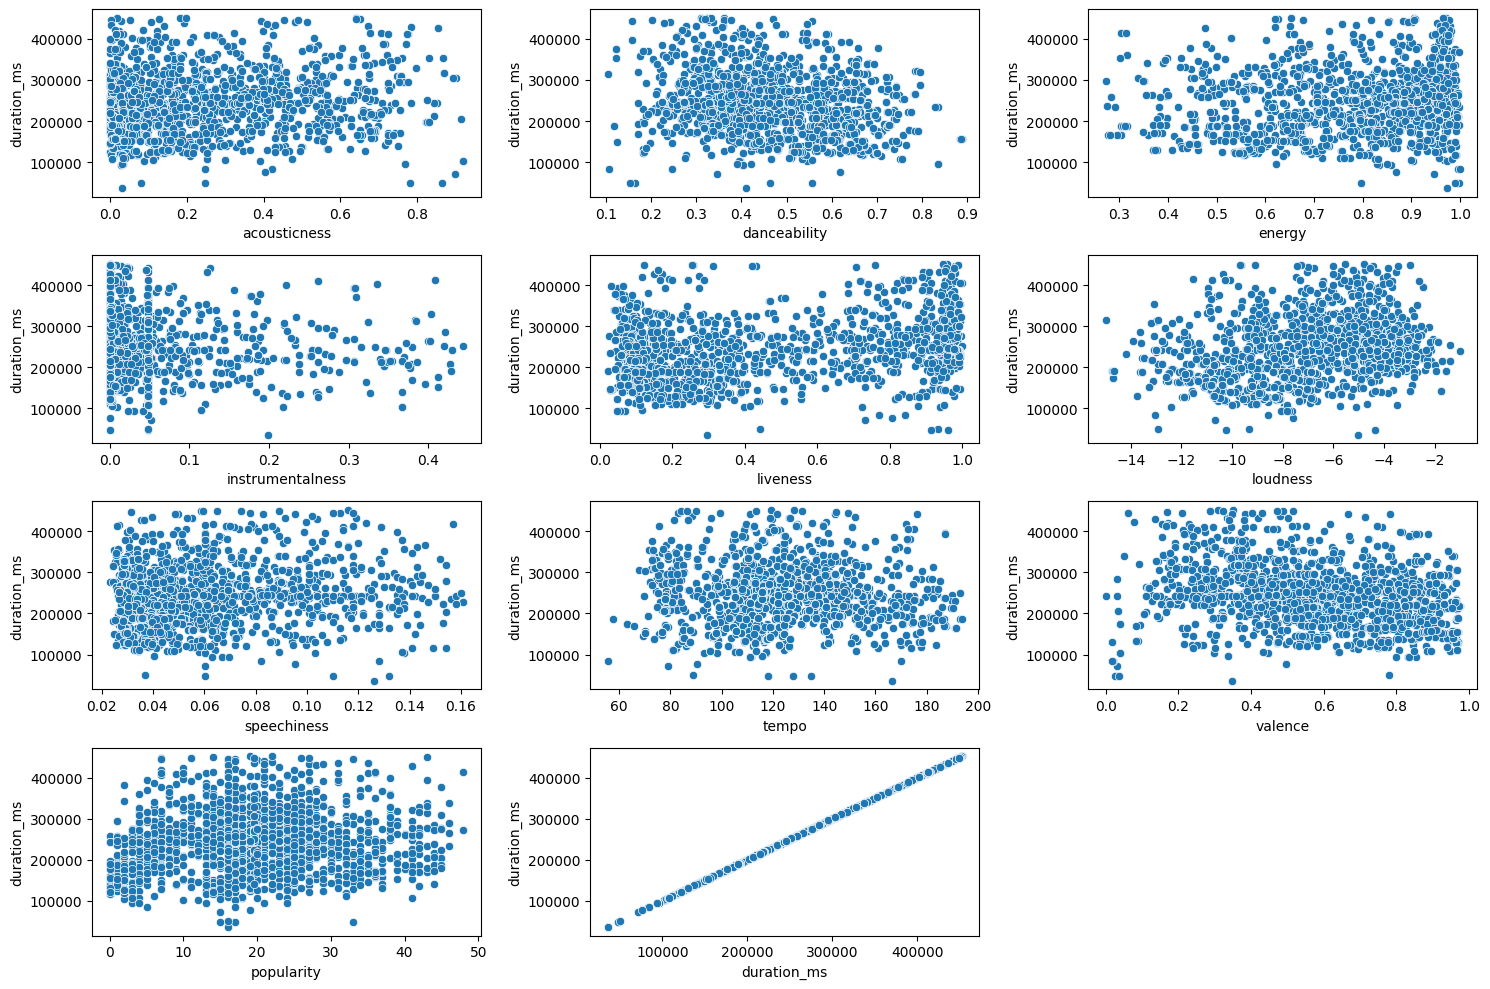

In [11]:
df_Clead_dataset,outlier_df = ObjOutlier.OutlierDeduction('iqr')


In [12]:
df_Clead_dataset.isnull().sum()

,0
acousticness,0
danceability,0
energy,0
instrumentalness,0
liveness,0
loudness,0
speechiness,0
tempo,0
valence,0
popularity,0


In [13]:
class EDA():
  def __init__(self,df):
    self.df = df

    self.df_dataset = self.df.copy()
    self.features_Column = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity','duration_ms']
    self.df_Features = self.df_dataset[self.features_Column]

  def Popular_Song(self,popularity_threshold):
    popular_songs_album = self.df_dataset[self.df_dataset['popularity'] >= popularity_threshold].groupby('album').size().reset_index(name='popular_songs_album')
    print(popular_songs_album.nlargest(2, 'popular_songs_album'))
    return popular_songs_album

  def Feature_Distribution(self):
    plt.figure(figsize=(15,10))
    for indx, col_plt in enumerate(self.features_Column):
      plt.subplot(len(self.features_Column)//3+1,3,indx+1)
      #sns.scatterplot(data=self.df_Features, x=col_plt,y='duration_ms',hue = self.df_dataset['name'])
      sns.histplot(data=self.df_Features[col_plt],kde = True)
      plt.title('Distribution of Feature')
      plt.tight_layout()
    plt.show()

  def Popularity_pairplot(self):
    columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence','popularity']
    sns.pairplot(self.df_dataset[columns],hue='popularity')
    plt.show()

  def Popularity_vs_Features(self):
    plt.figure(figsize=(15,10))
    columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence','popularity']
    for indx, col_plt in enumerate(columns):
      plt.subplot(len(columns)//3+1,3,indx+1)
      sns.scatterplot(data=self.df_Features, x=col_plt,y='popularity')

      plt.title(f'Distribution of Feature between Popularity vs {col_plt}')
      plt.tight_layout()
    plt.show()

  def HeatmapPlot(self):
    plt.figure(figsize=(10,7))
    sns.heatmap(self.df_Features.corr(),annot=True,cmap = 'Spectral')
    plt.show()






In [14]:
ObjEDA = EDA(df_song)
pplr_albm = ObjEDA.Popular_Song(75)


          album  popular_songs_album
0     Aftermath                    1
1  Let It Bleed                    1


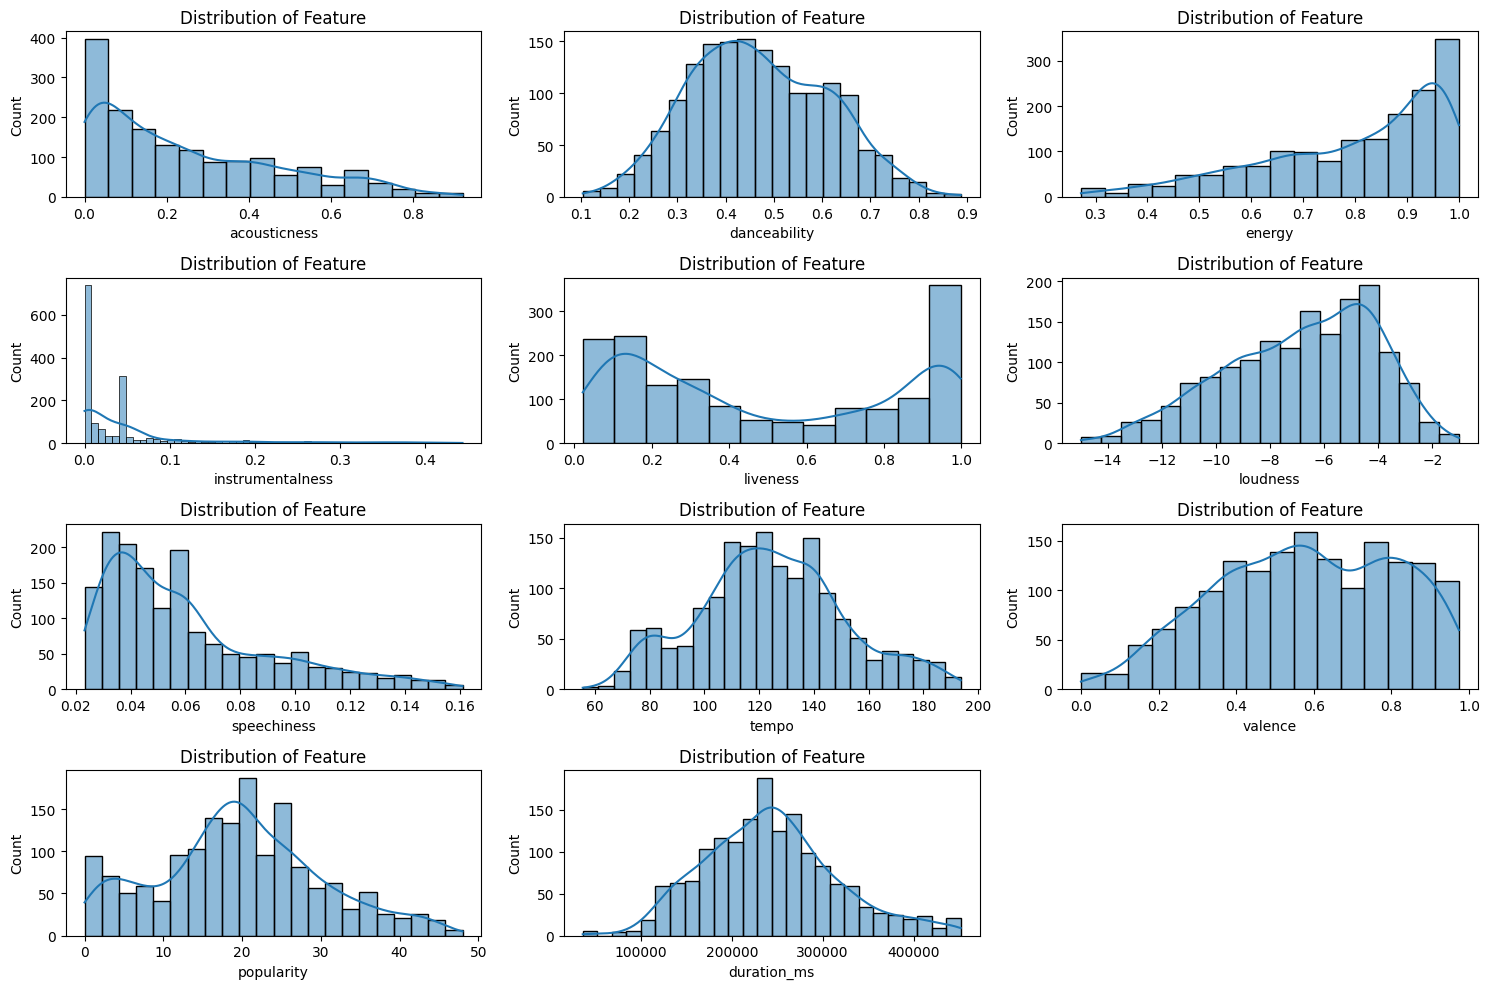

In [15]:
ObjEDA = EDA(df_Clead_dataset)
ObjEDA.Feature_Distribution()

In [16]:
ObjEDA.Popularity_pairplot()

Output hidden; open in https://colab.research.google.com to view.

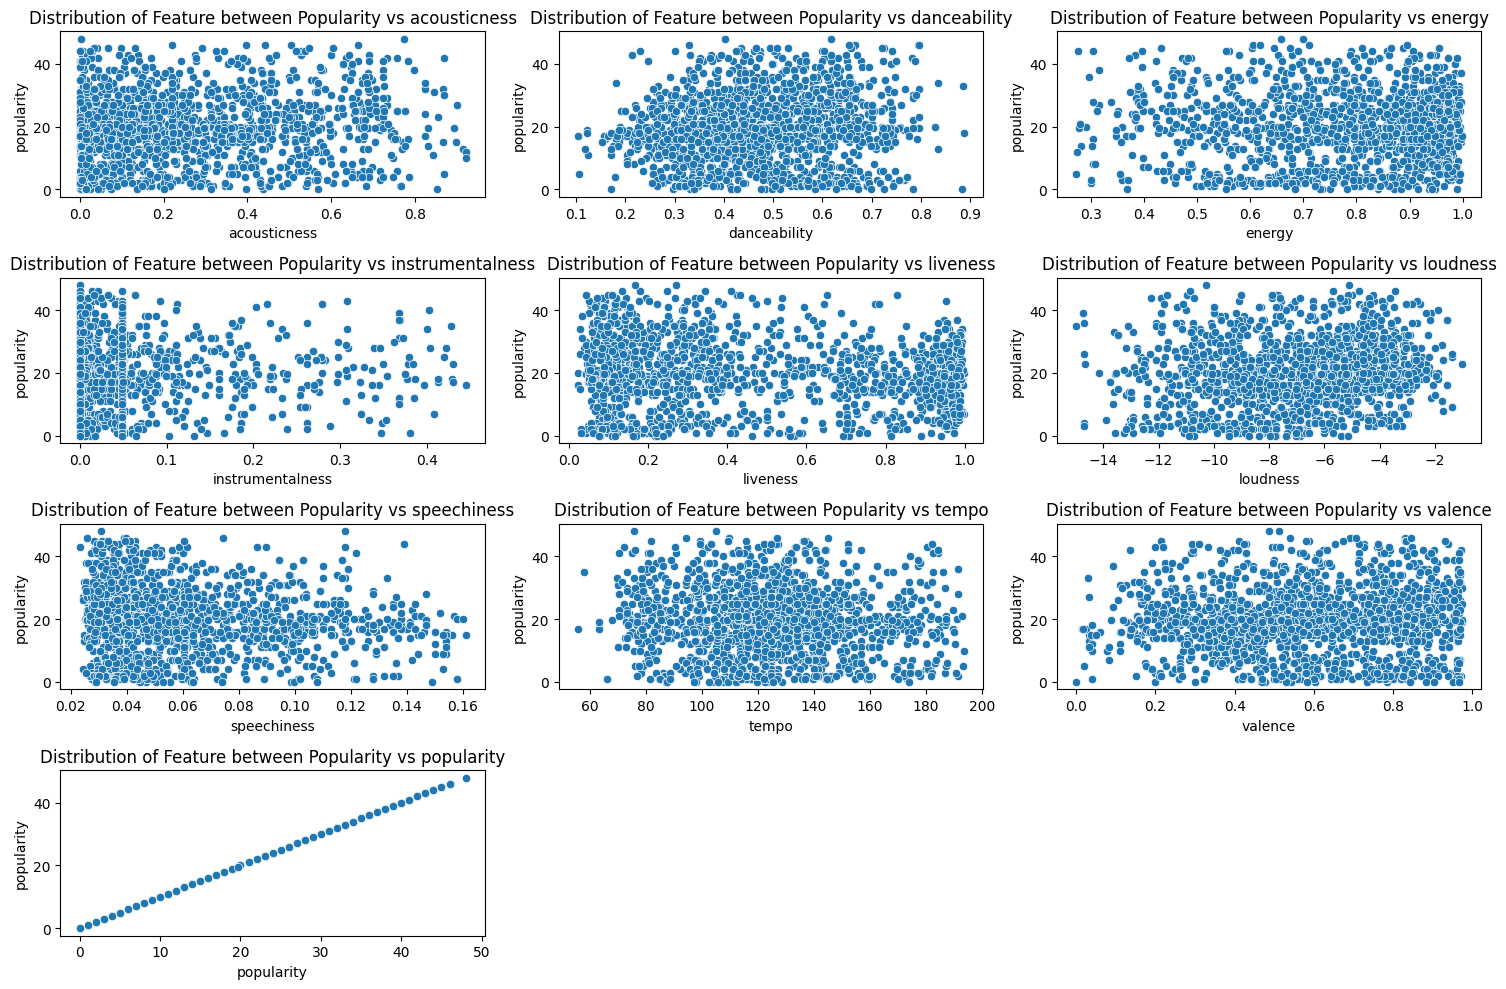

In [17]:
ObjEDA.Popularity_vs_Features()

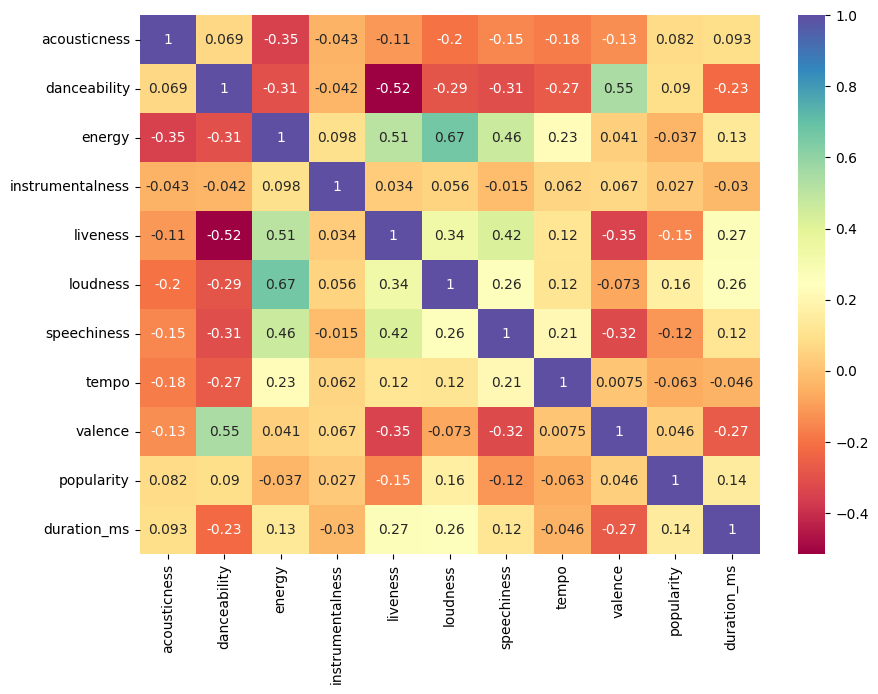

In [18]:
ObjEDA.HeatmapPlot()

In [19]:
class DimensionReduction():
  def __init__(self,df):
    self.df = df
    self.df_dataset = self.df.copy()
    self.features_Column = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','duration_ms']
    self.df_Features = self.df_dataset[self.features_Column]
    #print(self.df_Features.isnull().sum())
    #print(np.any(np.isnan(self.df_Features)))
    print(np.all(np.isfinite(self.df_Features)))

  def PCA_Analysis_withGridParam(self):
    param_grid_pca = {
    'pca__n_components': [2, 5, 10, 15, 20],
    'pca__svd_solver': ['auto', 'full', 'arpack', 'randomized'],
    'pca__whiten': [True, False],
    'pca__tol': [0.0, 0.001, 0.01],  # Example values
    'pca__iterated_power': ['auto', 5, 10],  # Example values
    'pca__random_state': [42]  # Ensuring reproducibility
    }

    pipeline = Pipeline([('Scaler',StandardScaler()),('pca',PCA())])
    grid_search = GridSearchCV(pipeline,param_grid_pca,cv=5)
    grid_search.fit(self.df_Features)

    best_n_componet = grid_search.best_params_['pca__n_components']
    best_svd_solver = grid_search.best_params_['pca__svd_solver']

    columns_pca = [f'PC{i+1}' for i in range(best_n_componet)]

    df_pca = pd.DataFrame(grid_search.transform(self.df_Features),columns=columns_pca)

    best_param = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    best_cv_result = grid_search.cv_results_
    best_pca = grid_search.best_estimator_.named_steps['pca']
    loadings = best_pca.components_



    relevant_features_pc1 = self.df_Features.columns[np.argsort(np.abs(loadings[0]))[::-1]]
    overall_feature_relevance = np.sum(np.abs(loadings), axis=0)
    relevant_features_overall = self.df_Features.columns[np.argsort(overall_feature_relevance)[::-1]]
    self.df_dataset['popularity_class'] = pd.cut(self.df_dataset['popularity'], bins=[0, 33, 66, 100], labels=['low', 'medium', 'high'])
    top_pc1_features = relevant_features_pc1[:5]

    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean') #You can also use 'median'
    self.df_Features[top_pc1_features] = imputer.fit_transform(self.df_Features[top_pc1_features])
    self.df_dataset['popularity_class'] = self.df_dataset['popularity_class'].fillna(self.df_dataset['popularity_class'].mode()[0])


    model = RandomForestClassifier()
    model.fit(self.df_Features[top_pc1_features], self.df_dataset['popularity_class'])
    feature_importances = model.feature_importances_
    sorted_indices = np.argsort(feature_importances)[::-1]
    # Select features based on importance
    important_features = top_pc1_features[np.argsort(feature_importances)[::-1]][:6] #Select Top 3 features

    print('Top 3 Important Features: ',important_features)

    # Train a final model with selected features
    final_model = RandomForestClassifier()
    final_model.fit(self.df_Features[important_features], self.df_dataset['popularity_class'])



    print('Relevant Features for PC1: ',relevant_features_pc1)
    print('Overall Relevant Features: ',relevant_features_overall)
    print('Best Param: ', grid_search.best_params_)
    print('Best Score',grid_search.best_score_)


    mean_scores = best_cv_result['mean_test_score']
    std_scores = best_cv_result['std_test_score']
    param_values = best_cv_result['params']


  def PCA_Without_GridParam(self):

    scaler = StandardScaler()
    df_feature_scaled = scaler.fit_transform(self.df_Features)


    # Apply PCA
    pca = PCA(n_components=2)
    pca_feature = pca.fit_transform(df_feature_scaled)

    loadings = pca.components_
    # Example: Get relevant features for the first component
    relevant_features_pc1 = self.df_Features.columns[np.argsort(np.abs(loadings[0]))[::-1]]

    # Example: Get overall feature relevance
    overall_feature_relevance = np.sum(np.abs(loadings), axis=0)
    relevant_features_overall = self.df_Features.columns[np.argsort(overall_feature_relevance)[::-1]]

    print('Relevant Features for PC1: ',relevant_features_pc1)
    print('Overall Relevant Features: ',relevant_features_overall)


    # Create a DataFrame with PCA results
    pca_df = pd.DataFrame(data=pca_feature, columns=['PCA1', 'PCA2'])

    # Plot PCA results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PCA1', y='PCA2', data=pca_df,palette='coolwarm',hue=self.df_dataset['popularity'])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Results')
    plt.show()

  def TSNE_Analysis(self):
    scaler = StandardScaler()
    df_feature_scaled = scaler.fit_transform(self.df_Features)


    param_grid_tsne = {
    'n_components': [2, 3],
    'perplexity': [5, 10, 20, 30, 40, 50],
    'learning_rate': [100, 200, 500, 1000],
    'n_iter': [1000, 2000, 3000],
    'metric': ['euclidean', 'manhattan', 'cosine']
    }

    # Create all combinations of parameters
    param_combinations = list(itertools.product(
        param_grid_tsne['n_components'],
        param_grid_tsne['perplexity'],
        param_grid_tsne['learning_rate'],
        param_grid_tsne['n_iter'],
        param_grid_tsne['metric']
    ))
    best_score = float('inf')
    best_params = None
    best_tsne_result = None
    for params in param_combinations:
      tsne = TSNE(
          n_components=params[0],
          perplexity=params[1],
          learning_rate=params[2],
          n_iter=params[3],
          metric=params[4],
          random_state=42)
      TSNE_Features = tsne.fit_transform(df_feature_scaled)

      kl_divergence = tsne.kl_divergence_
      if kl_divergence < best_score:
        best_score = kl_divergence
        best_params = params
        best_tsne_result = TSNE_Features



    print('Best Parameters:', best_params)
    print('Best KL Divergence:', best_score)

    best_tsne = TSNE( n_components=best_params[0], perplexity=best_params[1], learning_rate=best_params[2],
                      n_iter=best_params[3], metric=best_params[4], random_state=42  )
    best_tsne_Feature = best_tsne.fit_transform(df_feature_scaled)

    best_tsne_df = pd.DataFrame(data=best_tsne_Feature, columns=['TSNE1', 'TSNE2'])
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='TSNE1', y='TSNE2', data=best_tsne_df,palette='Set1',hue=self.df_dataset['popularity'])
    plt.xlabel('TSNE1')
    plt.ylabel('TSNE2')
    plt.title('TSNE Results')
    plt.show()



ObjDimRed = DimensionReduction(df_Clead_dataset)
#ObjDimRed = DimensionReduction(df_song)


True


Relevant Features for PC1:  Index(['liveness', 'energy', 'danceability', 'speechiness', 'loudness',
       'valence', 'duration_ms', 'tempo', 'acousticness', 'instrumentalness'],
      dtype='object')
Overall Relevant Features:  Index(['valence', 'energy', 'danceability', 'acousticness', 'loudness',
       'liveness', 'duration_ms', 'tempo', 'speechiness', 'instrumentalness'],
      dtype='object')


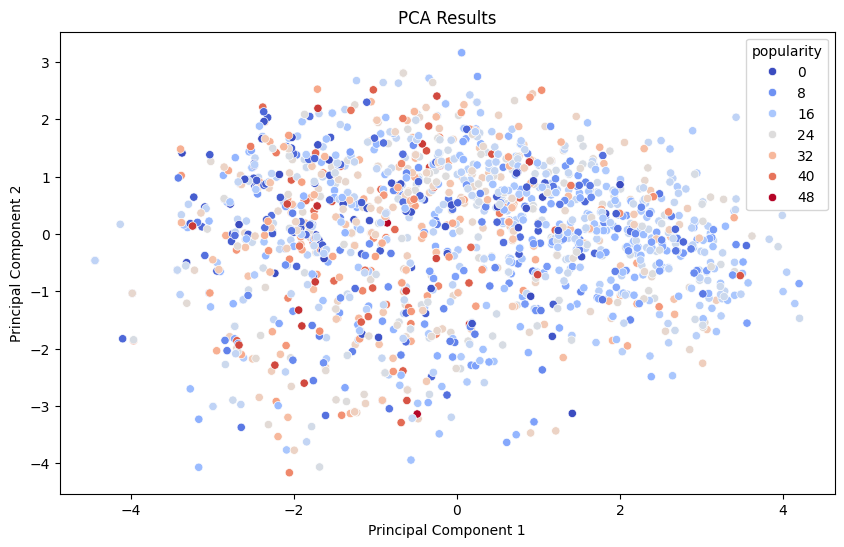

In [20]:
ObjDimRed.PCA_Without_GridParam()

In [21]:
ObjDimRed.PCA_Analysis_withGridParam()

Top 3 Important Features:  Index(['loudness', 'liveness', 'danceability', 'energy', 'speechiness'], dtype='object')
Relevant Features for PC1:  Index(['liveness', 'energy', 'danceability', 'speechiness', 'loudness',
       'valence', 'duration_ms', 'tempo', 'acousticness', 'instrumentalness'],
      dtype='object')
Overall Relevant Features:  Index(['loudness', 'speechiness', 'valence', 'duration_ms', 'danceability',
       'energy', 'acousticness', 'liveness', 'tempo', 'instrumentalness'],
      dtype='object')
Best Param:  {'pca__iterated_power': 'auto', 'pca__n_components': 10, 'pca__random_state': 42, 'pca__svd_solver': 'auto', 'pca__tol': 0.0, 'pca__whiten': False}
Best Score -13.480532549714132


In [22]:
#ObjDimRed.TSNE_Analysis()

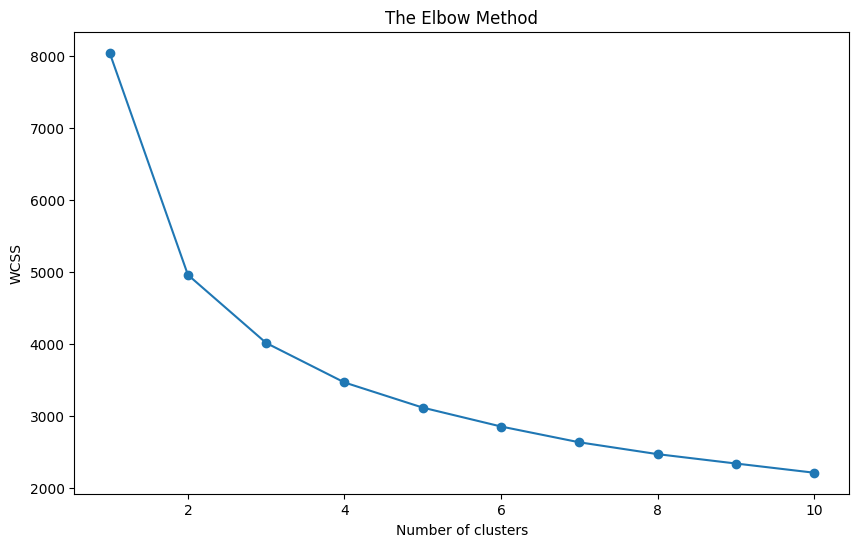

In [23]:
class FindKOptimal:
  def __init__(self,df):
    self.df = df
    self.df_dataset = self.df.copy()
    #self.features_Column = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity','duration_ms']
    self.features_Column = ['liveness', 'loudness', 'energy', 'speechiness', 'danceability']
    self.df_Features = self.df_dataset[self.features_Column]

  def Elbow_Method(self):
    scaler = StandardScaler()
    df_feature_scaled = scaler.fit_transform(self.df_Features)
    df_target = self.df_dataset['popularity']

    wcss = []

    for iterate in range(1,11):
      model = KMeans(n_clusters = iterate, init = 'k-means++', random_state = 42)
      model.fit(df_feature_scaled)
      wcss.append(model.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='-',)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.tight_layout
    plt.show()

  def silhouette_score(self,k_cluster):
    scaler = StandardScaler()
    df_feature_scaled = scaler.fit_transform(self.df_Features)
    kmeans = KMeans(n_clusters=k_cluster, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(df_feature_scaled)
    self.df_dataset['cluster'] = cluster_labels
    self.df_Features['cluster'] = cluster_labels

    silhouette_avg = silhouette_score(df_feature_scaled, cluster_labels)
    print('Silhoutee score: ',silhouette_avg)
    silhouette_samples_value = silhouette_samples(df_feature_scaled, cluster_labels)
    plt.figure(figsize=(10, 6))
    y_lower = 10
    for i in range(5):
        ith_cluster_silhouette_values = silhouette_samples_value[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
    return self.df_dataset,self.df_Features,silhouette_avg

ObjKOptimal = FindKOptimal(df_Clead_dataset)
#ObjKOptimal = FindKOptimal(df_song)
ObjKOptimal.Elbow_Method()

Silhoutee score:  0.26721248024617666


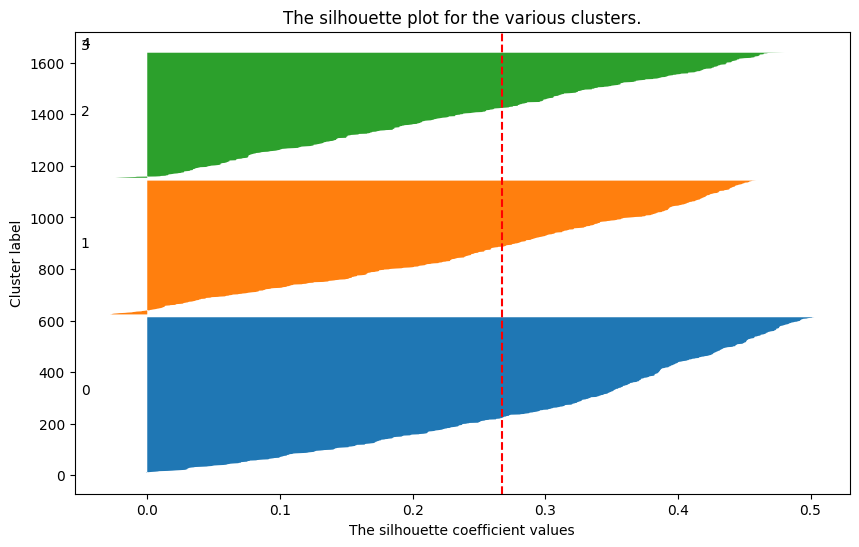

In [24]:
df_Silhoute_cluster = ObjKOptimal.silhouette_score(3)

Silhoutee score:  0.38767665762439163


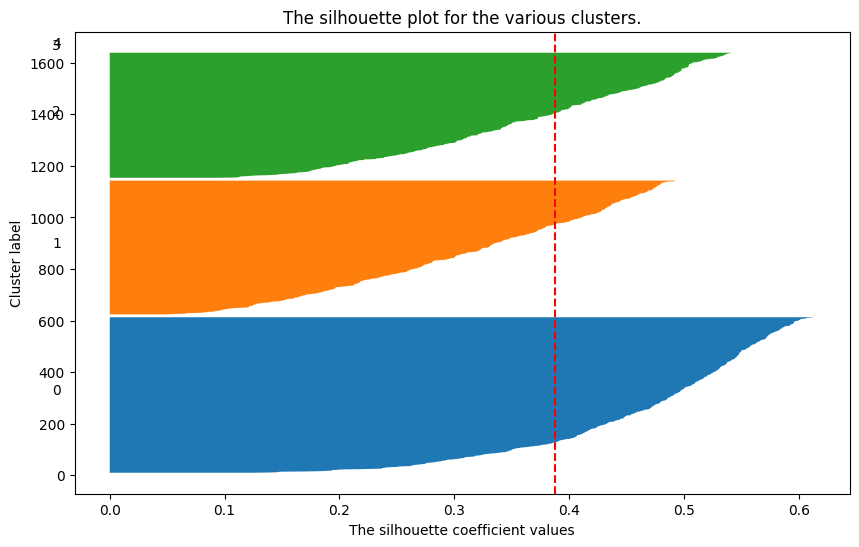

In [25]:
df_Silhoute_cluster = ObjKOptimal.silhouette_score(3)

In [26]:
class ClusterAlogrithm:
  def __init__(self,df):
    self.df = df
    self.df_dataset = self.df.copy()
    #self.features_Column = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity','duration_ms']
    self.features_Column = ['liveness', 'loudness', 'energy', 'speechiness', 'danceability']
    self.df_Features = self.df_dataset[self.features_Column]
    self.df_Features_scaled = pd.DataFrame()

  def DataTransformation(self):
    scaler = StandardScaler()
    self.df_feature_scaled = scaler.fit_transform(self.df_Features)

  def Silhoutee_Cluster(self,cluster_labels,clusterCount,clsutertype):
    silhouette_avg = silhouette_score(self.df_feature_scaled, cluster_labels)
    print('Silhoutee score: ',silhouette_avg)
    silhouette_samples_value = silhouette_samples(self.df_feature_scaled, cluster_labels)
    plt.figure(figsize=(7, 3))
    y_lower = 10
    for i in range(clusterCount):
        ith_cluster_silhouette_values = silhouette_samples_value[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f"The silhouette plot for the various clusters - {clsutertype}")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()


  def BIRCH_Cluster(self,n_clusters):
    threshold = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    branching_factors = [20,30,40,50,60,70,80]
    best_score =-1
    best_param = {}

    for threshold_value in threshold:
      for branching_factor in branching_factors:
        birch = Birch(n_clusters=n_clusters, threshold=threshold_value, branching_factor=branching_factor)
        cluster_labels = birch.fit_predict(self.df_feature_scaled)
        if(len(np.unique(cluster_labels))>1):
          sil_score = silhouette_score(self.df_feature_scaled, cluster_labels)
          if(sil_score>best_score):
            best_score = sil_score
            best_param = {'threshold': threshold_value, 'branching_factor': branching_factor}

    bric = Birch(n_clusters=n_clusters, threshold=best_param['threshold'], branching_factor=best_param['branching_factor'])
    cluster_labels = bric.fit_predict(self.df_feature_scaled)
    self.df_dataset['cluster'] = cluster_labels
    self.df_Features['cluster'] = cluster_labels
    davies_score = davies_bouldin_score(self.df_feature_scaled, cluster_labels)
    print('Davies Bouldin Score: ',davies_score)

    calinski_score = calinski_harabasz_score(self.df_feature_scaled, cluster_labels)
    print('Calinski Harabasz Score: ',calinski_score)
    self.Silhoutee_Cluster(cluster_labels,n_clusters,'BIRCH')

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(self.df_feature_scaled)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='rainbow', alpha=0.6)
    plt.title('Clusters Visualized with PCA')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

    return self.df_dataset,self.df_Features


  def KMeans_Cluster(self,k_cluster):
    kmeans = KMeans(n_clusters=k_cluster, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(self.df_feature_scaled)
    self.df_dataset['cluster'] = cluster_labels
    self.df_Features['cluster'] = cluster_labels
    self.Silhoutee_Cluster(cluster_labels,k_cluster,'KMeans')
    davies_score = davies_bouldin_score(self.df_feature_scaled, cluster_labels)
    print('Davies Bouldin Score: ',davies_score)

    calinski_score = calinski_harabasz_score(self.df_feature_scaled, cluster_labels)
    print('Calinski Harabasz Score: ',calinski_score)
    return self.df_dataset,self.df_Features

  def DBSCAN_Cluster(self,N_neighbors):
    neigh = NearestNeighbors(n_neighbors=N_neighbors)
    nbrs = neigh.fit(self.df_feature_scaled)
    distances, indices = nbrs.kneighbors(self.df_feature_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    Optimal_Epsilon = distances[int(len(distances)*0.95)]
    print('Optimal Epsilon values: ', Optimal_Epsilon)

    plt.plot(distances)
    plt.xlabel('Distance')
    plt.ylabel('Epsilon')
    plt.title('Optimal Episolon')
    plt.show()

    silhoutte_score = []
    min_sample_range = np.arange(2,50)

    for min_sample in min_sample_range:
      dbscan = DBSCAN(eps=Optimal_Epsilon, min_samples=min_sample)
      cluster_labels = dbscan.fit_predict(self.df_feature_scaled)
      if(len(np.unique(cluster_labels))>1):
        sil_score = silhouette_score(self.df_feature_scaled, cluster_labels)

        silhoutte_score.append(sil_score)
      else:
        silhoutte_score.append(-1)

    Optimal_min_sample = min_sample_range[np.argmax(silhoutte_score)]
    print('Optimal Min Sample: ',Optimal_min_sample)

    plt.plot(min_sample_range,silhoutte_score)
    plt.xlabel('Min Sample')
    plt.ylabel('Silhoutee Score')
    plt.title('Optimal Min Sample')
    plt.show()

    dbscan_optimal = DBSCAN(eps=Optimal_Epsilon, min_samples=Optimal_min_sample)
    cluster_labels = dbscan_optimal.fit_predict(self.df_feature_scaled)
    self.df_Features['cluster'] = cluster_labels

    davies_score = davies_bouldin_score(self.df_feature_scaled, cluster_labels)
    print('Davies Bouldin Score: ',davies_score)

    calinski_score = calinski_harabasz_score(self.df_feature_scaled, cluster_labels)
    print('Calinski Harabasz Score: ',calinski_score)

    self.Silhoutee_Cluster(cluster_labels,len(np.unique(cluster_labels)),'DBSCAN')




ObjCluster = ClusterAlogrithm(df_Clead_dataset)
#ObjCluster = ClusterAlogrithm(df_song)
ObjCluster.DataTransformation()

Optimal Epsilon values:  0.6419765352148225


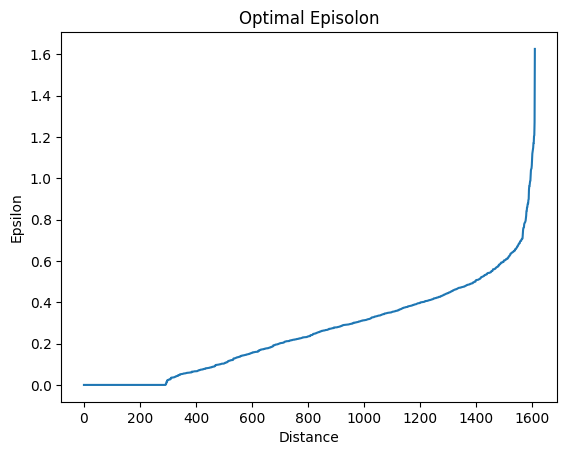

Optimal Min Sample:  18


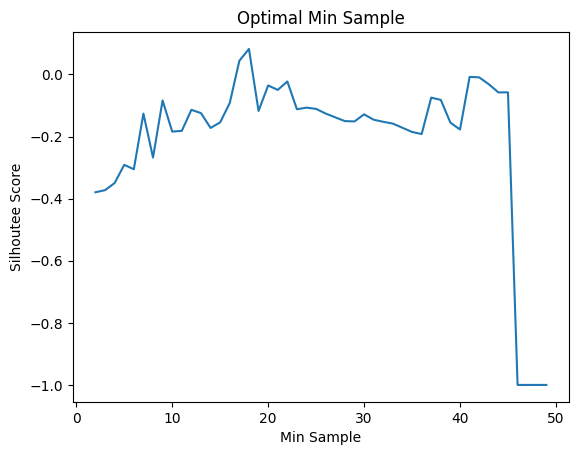

Davies Bouldin Score:  2.6093957139948185
Calinski Harabasz Score:  308.07231652050183
Silhoutee score:  0.0821557831303006


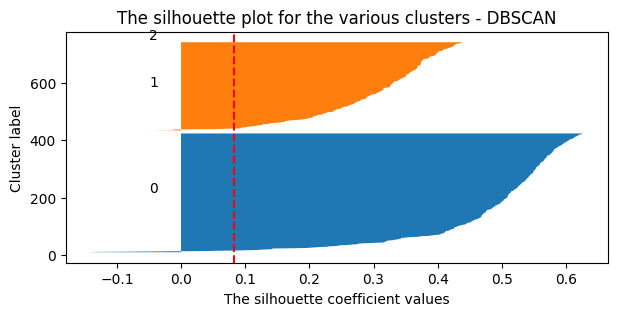

In [27]:
ObjCluster.DBSCAN_Cluster(3)

Silhoutee score:  0.26721248024617666


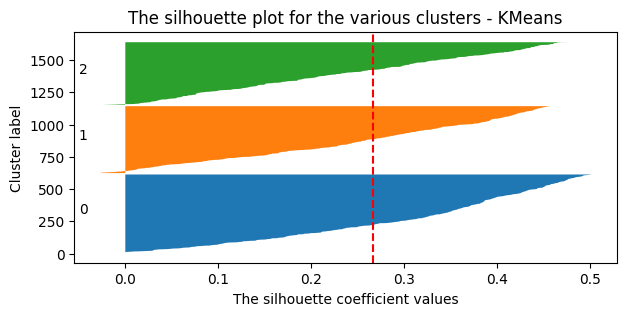

Davies Bouldin Score:  1.3363311404863225
Calinski Harabasz Score:  807.032652821396


In [28]:
df_fulldataset, df_feature_daataset= ObjCluster.KMeans_Cluster(3)

Davies Bouldin Score:  1.2128738429495085
Calinski Harabasz Score:  932.6815884299592
Silhoutee score:  0.32153506473032056


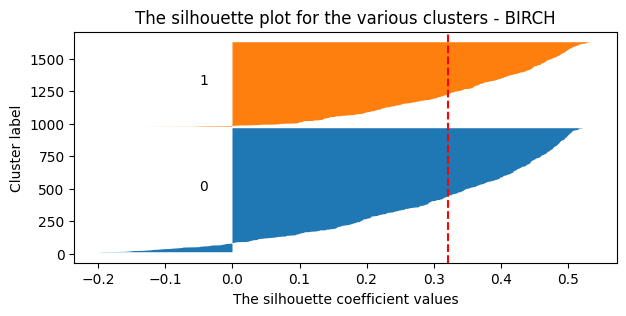

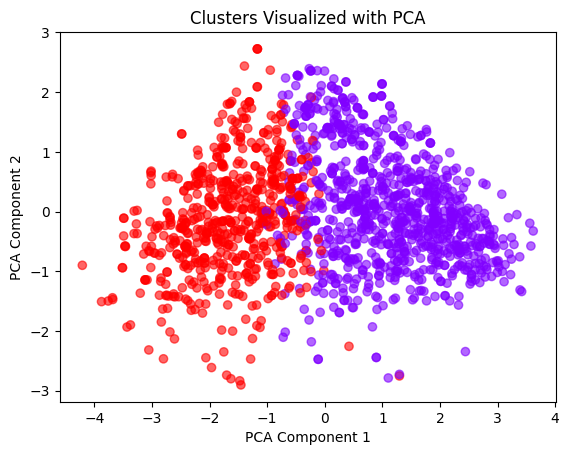

In [29]:
df_fulldataset, df_feature_daataset = ObjCluster.BIRCH_Cluster(2)

In [30]:
cluster_ImprovedFeature = df_fulldataset.groupby('cluster').mean()
#cluster_ImprovedFeature['Count_In_Each_Cluster'] = df_fulldataset.groupby('cluster')['popularity'].count().values()
cluster_ImprovedFeature['Count_In_Each_Cluster'] = df_fulldataset.groupby('cluster')['popularity'].count()
cluster_ImprovedFeature['Count_In_Each_Cluster']

,Count_In_Each_Cluster
cluster,
0,957
1,653


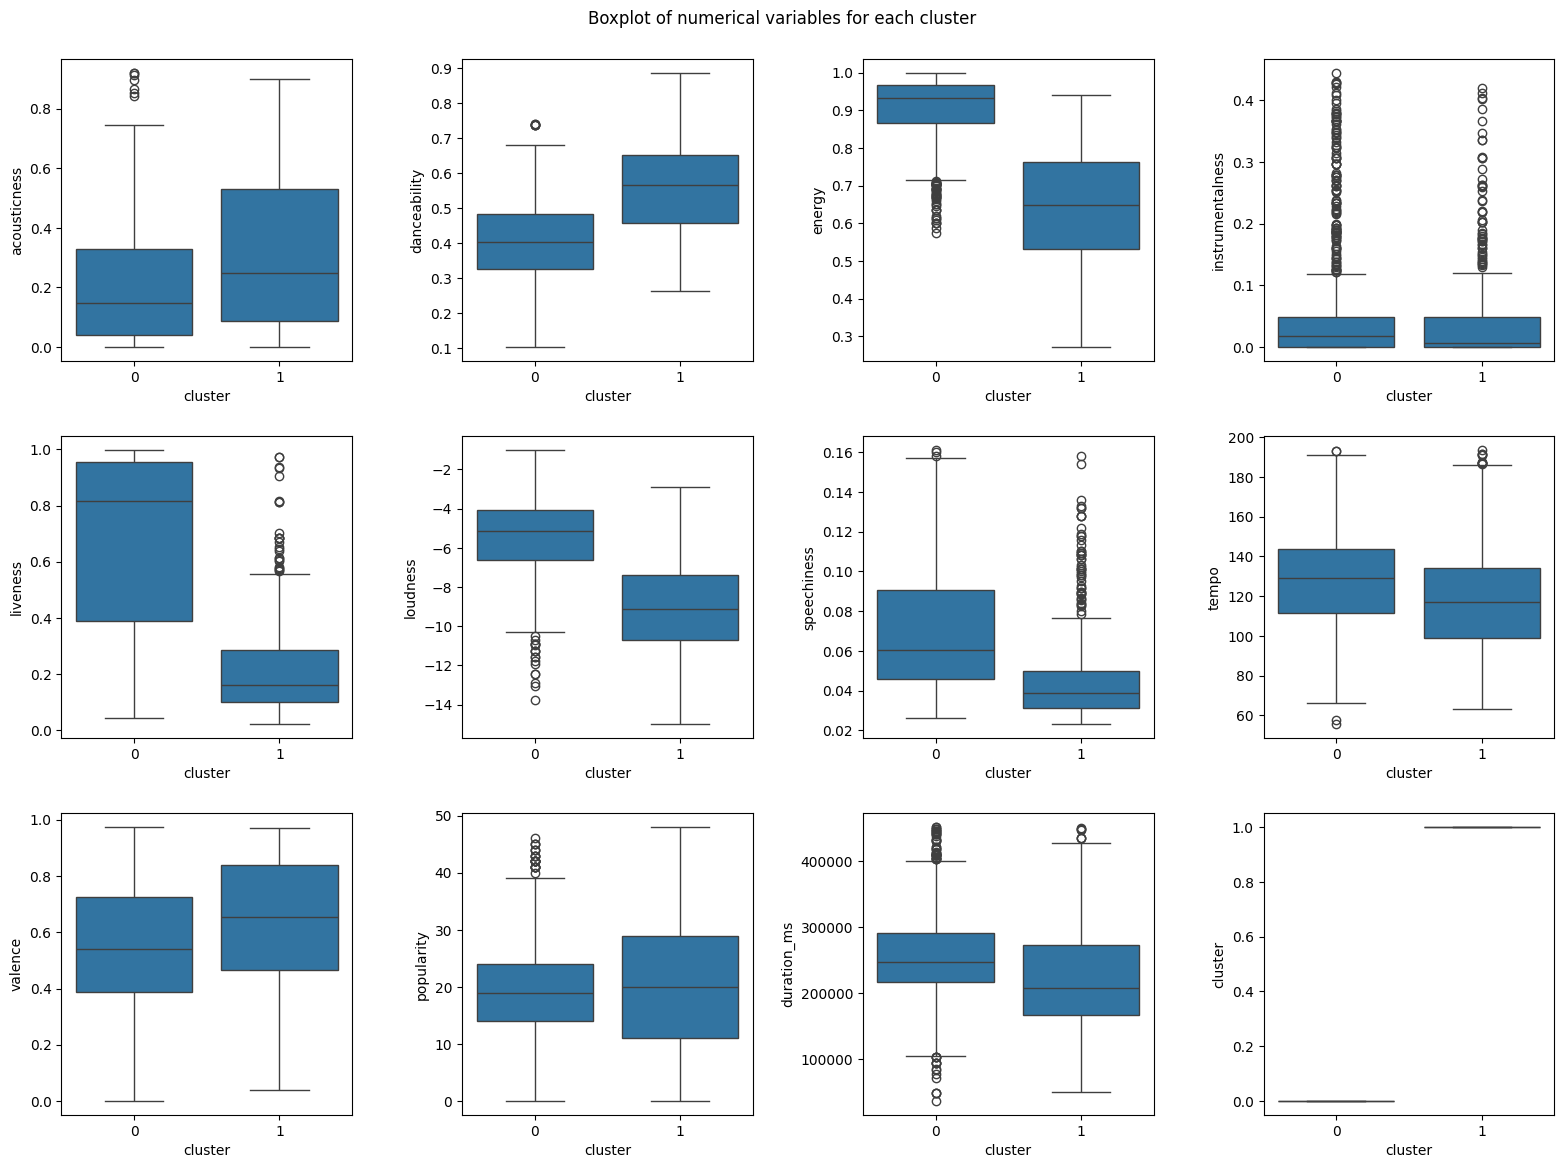

In [31]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12)) #Creating subplots in 3 rows and 4 columns to accomodate more plots.
fig.suptitle("Boxplot of numerical variables for each cluster")
axes = axes.flatten() # Flattening the axes array to a 1-D array for easier indexing

num_cols_to_plot = min(len(df_fulldataset.columns), len(axes)) #Setting a limit to avoid exceeding the maximum subplots

for i, col in enumerate(df_fulldataset.columns[:num_cols_to_plot]): #Iterating over relevant columns of dataframe
    sns.boxplot(ax=axes[i], y=df_fulldataset[col], x=df_fulldataset["cluster"])

fig.tight_layout(pad=2.0)
plt.show() #Adding this line is a good practice for explicitly showing the plot.

Observation:

* KMeans and DBSCAN cluster not given sufficient silhoutte score
* BIRCH cluster given the resonable silhoutte score of 0.32 with cluster size of 2

#Metrices
* Average Silhouette Score: The silhouette score is approximately 0.32, indicating moderate clustering performance. While it's not exceptional, it's not poor either. It suggests that the data points are reasonably well-clustered.

* Additional Metrics:
Davies-Bouldin Index (1.21): A lower value indicates better clustering. This score is reasonably good.

* Calinski-Harabasz Index (932.68): A higher value indicates better-defined clusters. This score is also good.

* ['liveness', 'loudness', 'energy', 'speechiness', 'danceability'] are most important feature in the dataset

* Most liveness,energitic, speechiness and loudness songs are present in the Cohort cluster 0
* Most accoustic & Danceablity songs are present in the Cluster 01
*

